In [1]:
%matplotlib widget

import os
import numpy as np
import pandas as pd
import itertools as it
from glob import glob
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.io import fits

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch

from lvmdrp.core.constants import LVM_UNAM_URL
from lvmdrp.utils.examples import fetch_example_data, get_frames_metadata, fix_lamps_metadata, get_masters_metadata

from lvmdrp.core import rss, image, spectrum1d
from lvmdrp.functions import imageMethod, rssMethod, fluxCalMethod

plt.style.use("seaborn-v0_8-talk")

In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = "./data"
os.makedirs(output_path, exist_ok=True)

# create processed frames path template
out_main_path = os.path.join(output_path, "lvm-{kind}-{camera}-{expnum}.fits")
out_calib_path = os.path.join(output_path, "lvm-{mjd}-{kind}-{camera}-{exptime}.fits")

In [3]:
# extract metadata
frames_table = get_frames_metadata(path=os.path.join(data_path, "lco_com"), ignore_cache=False).to_pandas()
frames_table = frames_table.loc[~frames_table.mjd.isin([60008,60009,60037,60038])]
# fix arc lamps metadata
fix_lamps_metadata(metadata=frames_table, lamp_names="argon neon ldls hgne xenon krypton".split())

# get master calibration metadata
masters_fiberflat = get_masters_metadata(path_pattern=out_calib_path, mjd="super", kind="mfiberflat", exptime="x").sort_values("camera")

[INFO]: loading cached metadata from '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/frames_table.pkl'


In [4]:
mfiberflat = masters_fiberflat.iloc[2]

# imageMethod.findPeaksAuto_drp(
#     in_image=mfiberflat.path,
#     out_peaks=out_calib_path.format(mjd=mfiberflat.mjd, kind="mpeaks", camera=mfiberflat.camera, exptime=mfiberflat.exptime).replace(".fits", ".txt"),
#     nfibers=638, slice=3200, threshold=0, method="gauss", median_box=10, median_cross=1, plot=1
# )
# plt.gcf().set_size_inches(15,10)
# plt.tight_layout()

In [5]:
# imageMethod.tracePeaks_drp(
#     in_image=mfiberflat.path,
#     out_trace=out_calib_path.format(mjd=mfiberflat.mjd, kind="mtrace", camera=mfiberflat.camera, exptime=int(mfiberflat.exptime) if mfiberflat.exptime != "x" else mfiberflat.exptime),
#     in_peaks=out_calib_path.format(mjd=mfiberflat.mjd, kind="mpeaks", camera=mfiberflat.camera, exptime=int(mfiberflat.exptime) if mfiberflat.exptime != "x" else mfiberflat.exptime).replace(".fits", ".txt"),
#     steps=30, coadd=1, threshold=0, max_diff=2, method="gauss", median_box=10, median_cross=1, plot=1,
#     poly_disp=2
# )

In [6]:
# from lvmdrp.core import tracemask
# from astropy.visualization import simple_norm

# trace_path = out_calib_path.format(mjd=mfiberflat.mjd, kind="mtrace", camera=mfiberflat.camera, exptime=mfiberflat.exptime)

# trace = tracemask.TraceMask()
# trace.loadFitsData(trace_path)

# fiberflat = image.loadImage(trace_path.replace("mtrace", "mfiberflat"))

# fiberflat_data = fiberflat._data
# # fiberflat_data[fiberflat._mask] = np.nan

# norm = simple_norm(fiberflat_data, stretch="log", max_percent=95)
# fig, ax = plt.subplots(figsize=(10,10))
# ax.imshow(fiberflat_data, norm=norm, origin="lower", cmap="binary_r")

# for ifiber in range(trace._fibers):
#     fiber = trace.getSpec(ifiber)
#     ax.plot(fiber._pixels, fiber._data, color=plt.cm.rainbow(ifiber/trace._fibers), lw=1)

In [7]:
# imageMethod.traceFWHM_drp(
#     in_image=out_calib_path.format(mjd=mfiberflat.mjd, kind=mfiberflat.kind, camera=mfiberflat.camera, exptime=mfiberflat.exptime),
#     in_trace=out_calib_path.format(mjd=mfiberflat.mjd, kind="mtrace", camera=mfiberflat.camera, exptime=mfiberflat.exptime),
#     out_fwhm=out_calib_path.format(mjd=mfiberflat.mjd, kind="mfwhm", camera=mfiberflat.camera, exptime=mfiberflat.exptime),
#     # blocks=20, steps=30, coadd=1, poly_disp=2
#     blocks=32, steps=30, coadd=20, threshold_flux=50.0, poly_disp=5, clip="1.5,3.0"
# )

In [8]:
# imageMethod.extractSpec_drp(
#     in_image=out_calib_path.format(mjd=mfiberflat.mjd, kind=mfiberflat.kind, camera=mfiberflat.camera, exptime=mfiberflat.exptime),
#     in_trace=out_calib_path.format(mjd=mfiberflat.mjd, kind="mtrace", camera=mfiberflat.camera, exptime=mfiberflat.exptime),
#     fwhm=out_calib_path.format(mjd=mfiberflat.mjd, kind="mfwhm", camera=mfiberflat.camera, exptime=mfiberflat.exptime),
#     out_rss=out_calib_path.format(mjd=mfiberflat.mjd, kind="rss", camera=mfiberflat.camera, exptime=mfiberflat.exptime),
#     parallel=5, method="optimal", plot=1
# )

In [9]:
from lvmdrp.core.tracemask import TraceMask

trace_mask = TraceMask()
trace_mask.loadFitsData(out_calib_path.format(mjd=mfiberflat.mjd, kind="mtrace", camera=mfiberflat.camera, exptime=mfiberflat.exptime))
trace_fwhm = TraceMask()
trace_fwhm.loadFitsData(out_calib_path.format(mjd=mfiberflat.mjd, kind="mfwhm", camera=mfiberflat.camera, exptime=mfiberflat.exptime))



In [10]:
img = image.loadImage(out_calib_path.format(mjd=mfiberflat.mjd, kind=mfiberflat.kind, camera=mfiberflat.camera, exptime=mfiberflat.exptime))

In [11]:
icolumn = 3200

slice_img = img.getSlice(icolumn, axis="y")
slice_img._error = np.sqrt(slice_img._data)
slice_trace = trace_mask.getSlice(icolumn, axis="y")
trace = slice_trace[0]
fwhm = trace_fwhm.getSlice(icolumn, axis="y")[0]

# bad_fiber = (slice_trace[2] == 1) | ((slice_trace[0] < 0) | slice_trace[0] > len(slice_img._data) - 1)
bad_fiber = np.logical_or(
    (slice_trace[2] == 1),
    np.logical_or(
        slice_trace[0] < 0, slice_trace[0] > len(slice_img._data) - 1
    ),
)
good_fiber = ~bad_fiber

[WARNING]: invalid value encountered in divide (RuntimeWarning)


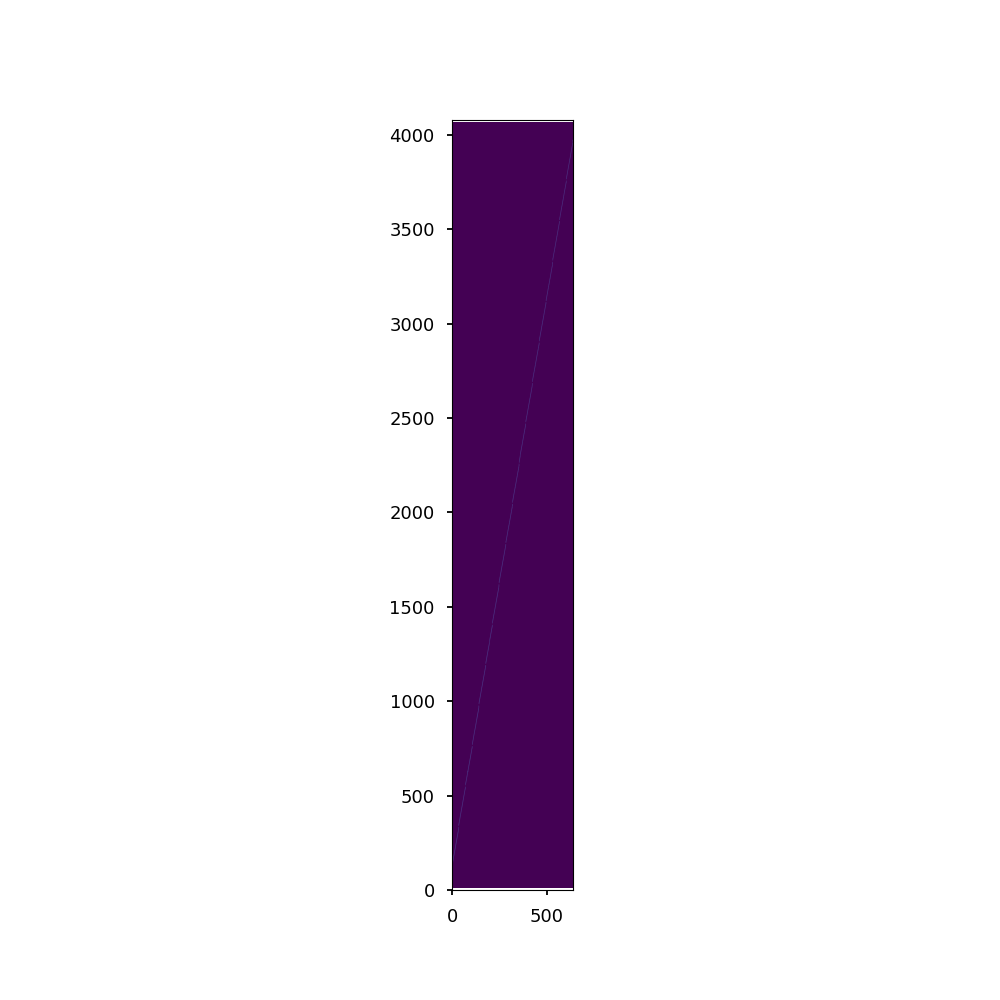

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[WARNING]: invalid value encountered in divide (RuntimeWarning)
(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

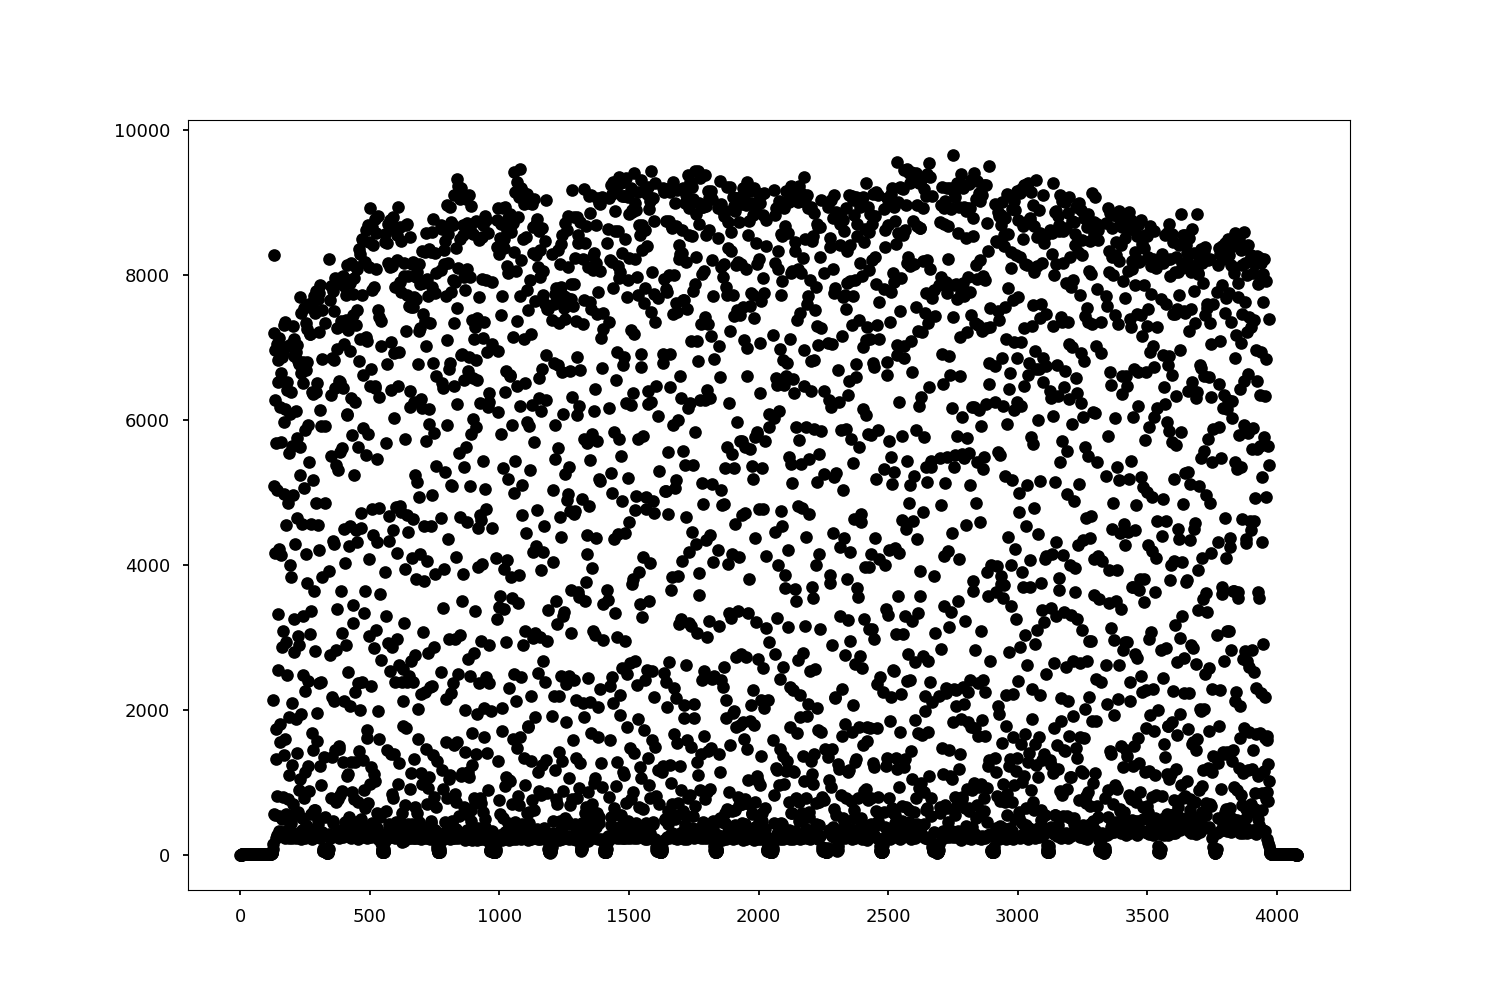

In [12]:
indices = np.indices((img._dim[0], np.sum(good_fiber)))
result = slice_img.obtainGaussFluxPeaks(
    trace[good_fiber], fwhm[good_fiber], indices, plot=True
)

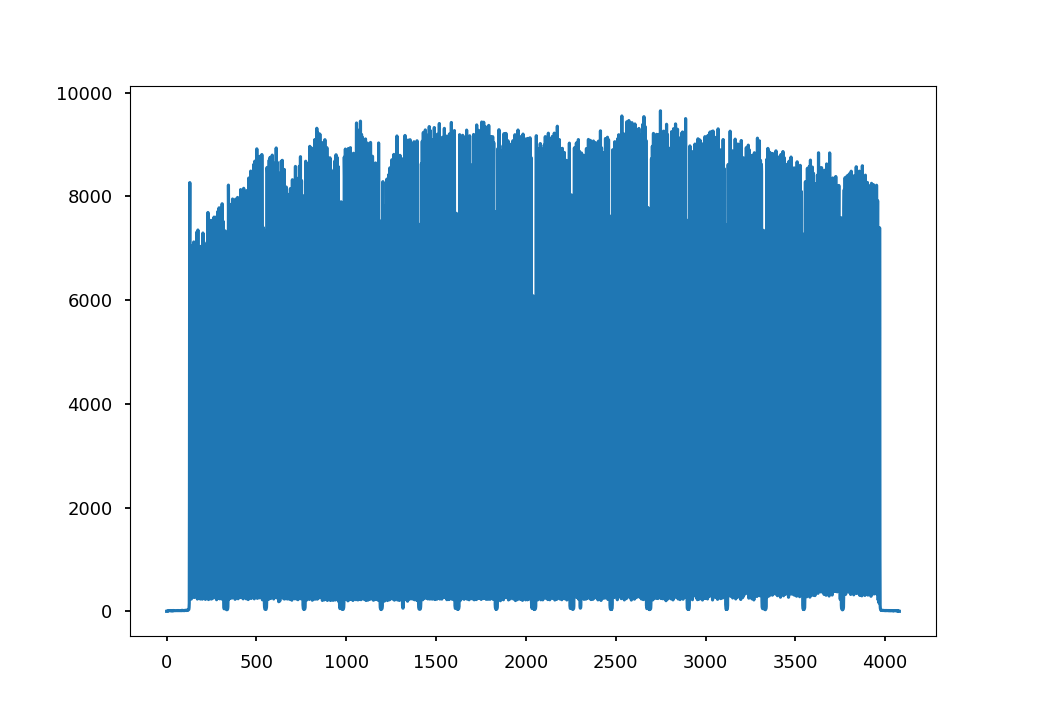

In [14]:
plt.figure()
plt.plot(slice_img._data)

7656

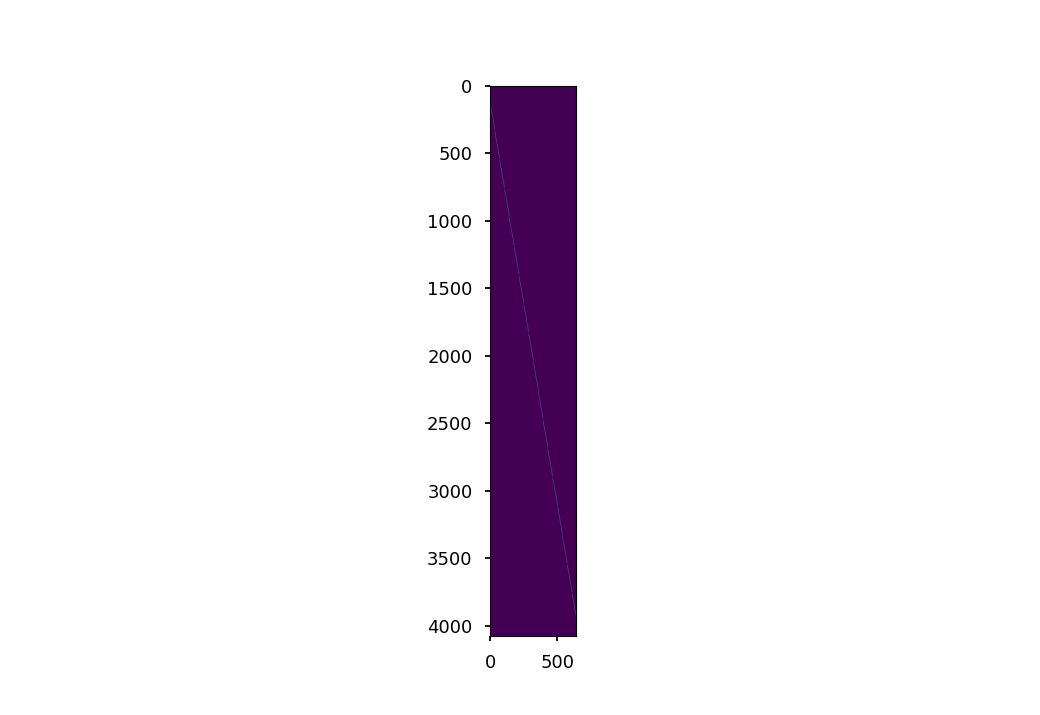

In [24]:
plt.figure()
plt.imshow(np.sqrt(result[-2]))

np.isnan(result[-1]).sum()